In [1]:
import pandas as pd
import numpy as np

# --- Cargar dataset de interés ---
interest_df = pd.read_csv("bitcoin_trends_daily_2020_2025.csv", parse_dates=['Date'])

# --- Simular precios de Bitcoin ---
countries = interest_df['country'].unique()
prices_list = []

for country in countries:
    df_country = interest_df[interest_df['country']==country].copy()
    df_country = df_country[['Date']].drop_duplicates().reset_index(drop=True)
    
    # Precios simulados
    np.random.seed(42)
    df_country['crypto'] = 'Bitcoin'
    df_country['price'] = 10000 + np.cumsum(np.random.normal(0, 200, len(df_country)))
    
    # Volatilidad diaria (std móvil 7 días)
    df_country['volatility'] = df_country['price'].rolling(7).std().fillna(0)
    
    # Añadir país
    df_country['country'] = country
    prices_list.append(df_country)

prices_df = pd.concat(prices_list, ignore_index=True)

# --- Merge interés y volatilidad ---
merged_df = interest_df.merge(prices_df[['Date','country','volatility']], on=['Date','country'], how='left')


In [2]:
# --- Correlación Interest vs Volatility por país ---
correlation = merged_df.groupby('country')[['interest','volatility']].corr().iloc[0::2,-1]
print("Correlación Interest vs Volatility por país:")
print(correlation)


Correlación Interest vs Volatility por país:
country          
BR       interest    0.021234
CN       interest   -0.020229
DE       interest    0.017311
GB       interest    0.018137
IN       interest    0.028245
JP       interest    0.122009
KR       interest    0.056312
MX       interest    0.004055
SG       interest    0.031280
US       interest   -0.029308
Name: volatility, dtype: float64


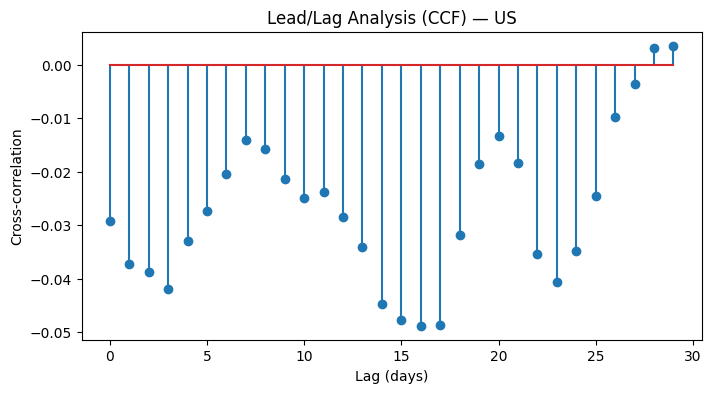

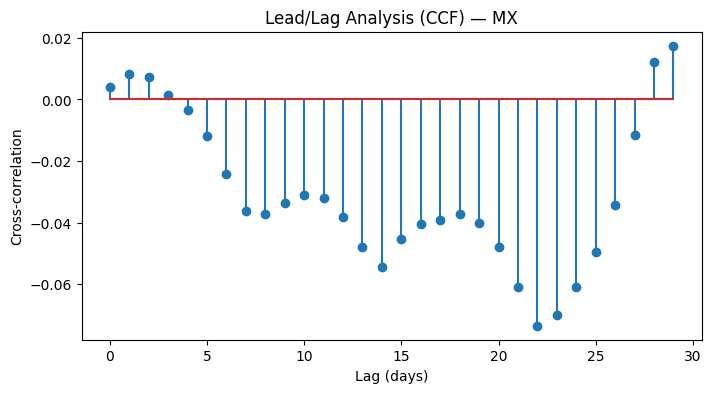

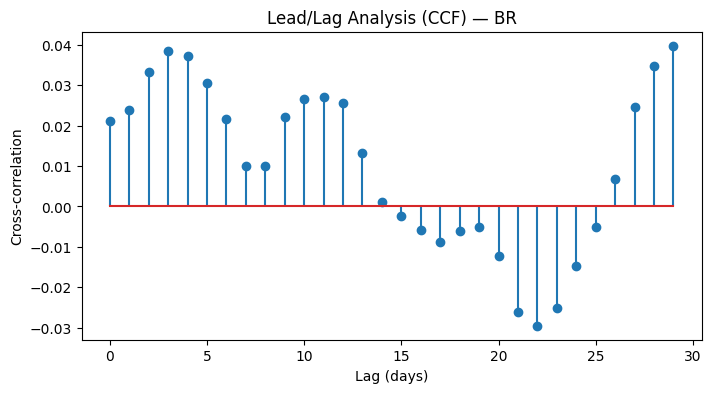

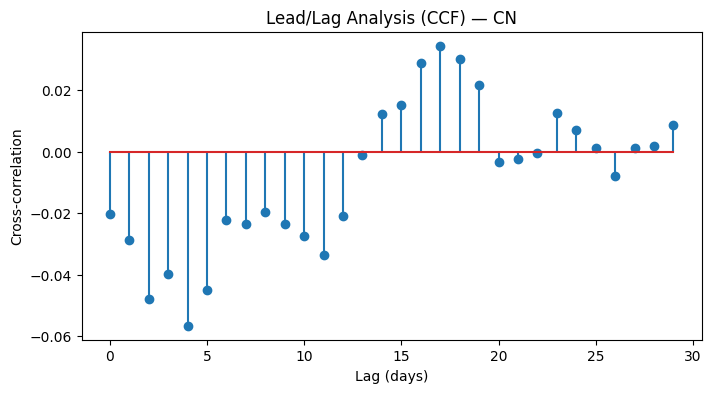

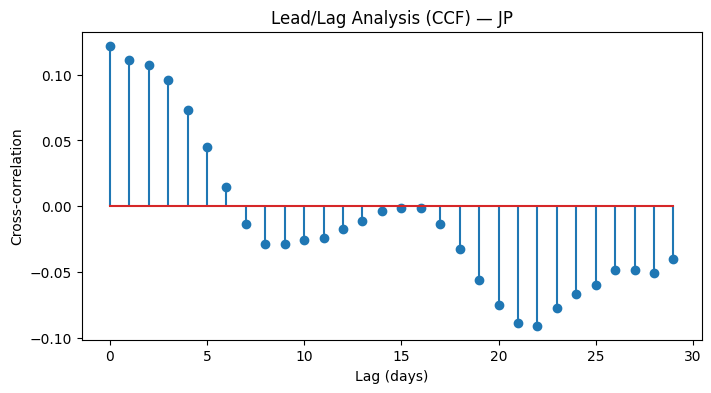

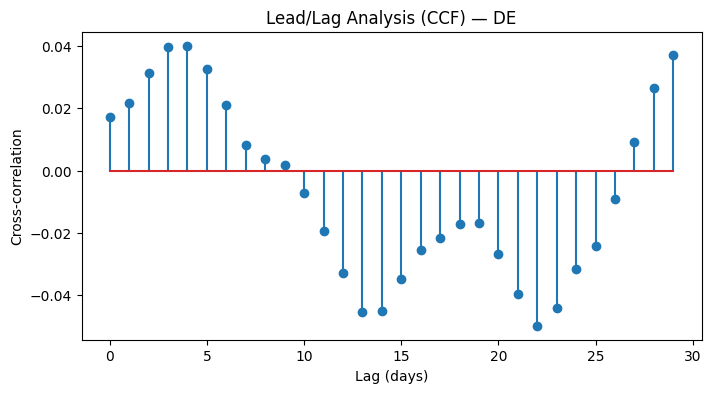

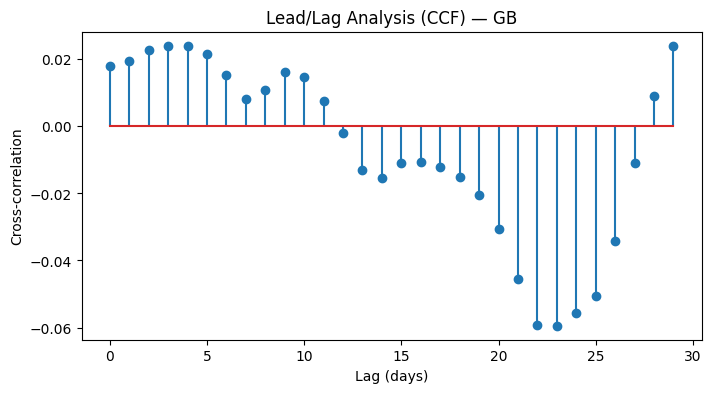

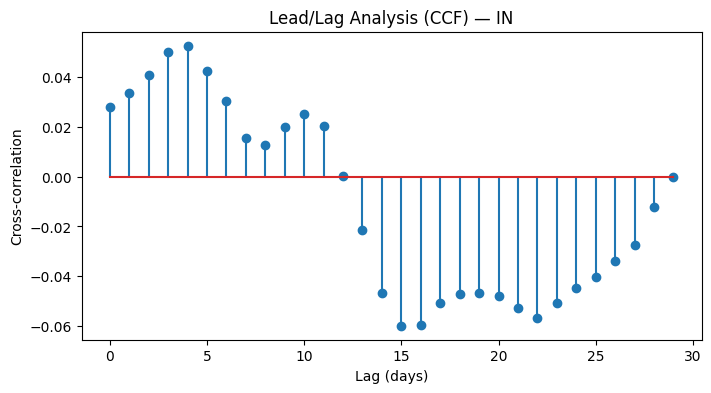

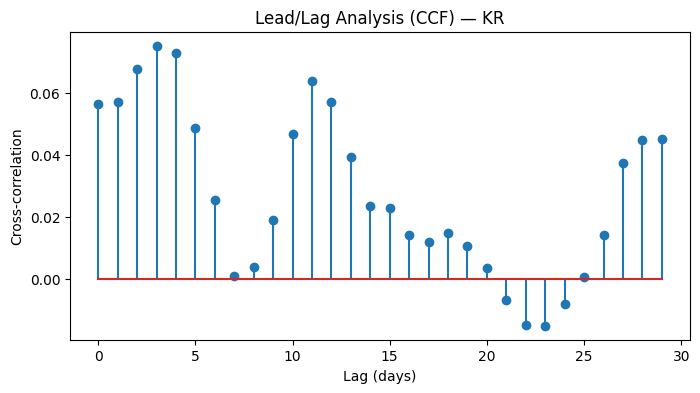

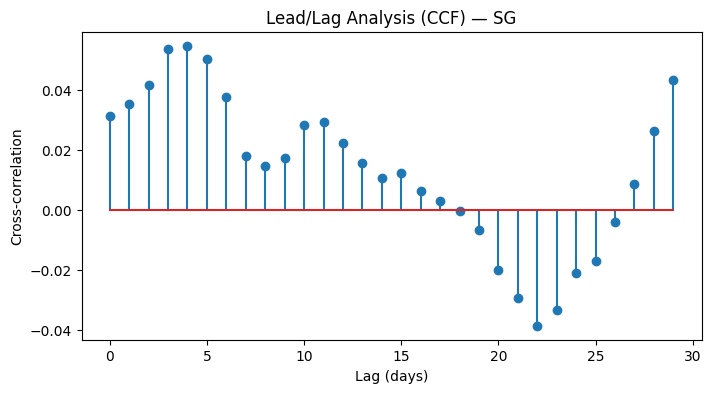

In [3]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf

# --- Lead/Lag Analysis ---
for country in countries:
    df = merged_df[merged_df['country']==country].copy()
    interest_series = df['interest'] - df['interest'].mean()
    volatility_series = df['volatility'] - df['volatility'].mean()
    
    ccf_values = ccf(interest_series, volatility_series)[:30]  # Primeros 30 días de lag
    lags = np.arange(len(ccf_values))
    
    plt.figure(figsize=(8,4))
    plt.stem(lags, ccf_values)
    plt.title(f"Lead/Lag Analysis (CCF) — {country}")
    plt.xlabel("Lag (days)")
    plt.ylabel("Cross-correlation")
    plt.show()
